## Import Python Sklearn Libraries and NLTK

In [31]:
import csv
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, classification_report
from sklearn import svm

import nltk

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

import re

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load the dataset and remove invalid data

In [2]:
raw_data = pd.read_csv('categories.csv', sep = ';', header = None)
raw_data.columns = ["Text", "Class"]
raw_data = raw_data.dropna()
raw_data.head(10)

,Text,Class
0,i feel lots of crypto has exhausted itself,1.0
1,How are you guys feeling today ??? :Bear: or ...,1.0
2,Did not take a trade today,1.0
3,Just entered eos long trade 👌,1.0
4,Anything good to buy now? Or did I miss it 😭,1.0
5,GL trading tonight guys. I'm off to eat dinne...,1.0
6,Okay my long position is still open on eth,1.0
7,morning guys any trades avaiable?,1.0
8,What’s everybodies thoughts today?,1.0
9,Are you guys more bullish or bearish for this ...,1.0


<Axes: >

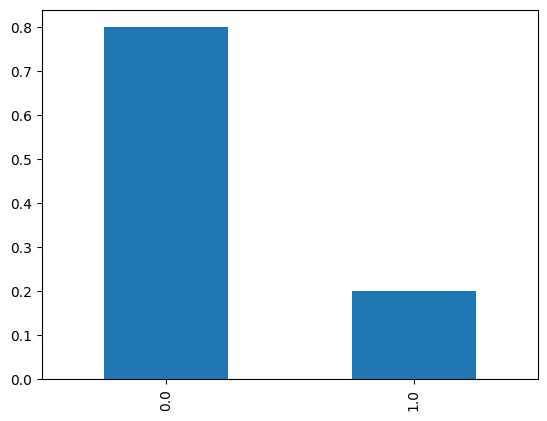

In [3]:
raw_data['Class'].value_counts(normalize = True).plot.bar()

## Data Sampling (Undersampling)

In [4]:
class_1_data = raw_data[raw_data["Class"] == 1]
class_0_data = raw_data[raw_data["Class"] == 0]

print("Samples of Class 0 : ", len(class_0_data.index))
print("Samples of Class 1 : ", len(class_1_data.index))

Samples of Class 0 :  23099
Samples of Class 1 :  5762


In [8]:
balanced_dataset = pd.concat([class_1_data, class_0_data.sample(len(class_1_data.index))], ignore_index=True)
print("Samples of Balanced Dataset : ", len(balanced_dataset.index))

Samples of Balanced Dataset :  11524


## Data Preprocessing

In [9]:
lemmatizer = WordNetLemmatizer()
with open('specialWords.txt') as file:
    special_words = [line.strip() for line in file]

In [14]:
## cleaning text data, remove special charactors, numbers, puncatations, stopwords removing, lower casing, skip special words
cleaned_text = []
for idx in range(len(balanced_dataset)):
    sentence = balanced_dataset['Text'][idx]
    removeSpecialChars = str(sentence).translate ({ord(c): " " for c in "!@#$%^&*()[]{};:,./<>?\|`~-=_+"})
    pattern = r'[0-9]'
    new_string = re.sub(pattern, '', removeSpecialChars)
    new_string = re.sub(' +', ' ', new_string)
    new_string = ' '.join([word for word in new_string.split() if word not in stopwords.words("english")])
    new_string = ' '.join( [lemmatizer.lemmatize(w).lower() for w in new_string.split() if len(w)>1 and w not in special_words] )
    cleaned_text.append(new_string)

balanced_dataset['cleaned_text'] = cleaned_text

In [15]:
balanced_dataset.head(30)

,Text,Class,cleaned_text
0,i feel lots of crypto has exhausted itself,1.0,feel lot crypto exhausted
1,How are you guys feeling today ??? :Bear: or ...,1.0,how guy feeling today bear bull
2,Did not take a trade today,1.0,did take trade today
3,Just entered eos long trade 👌,1.0,just entered eos long trade
4,Anything good to buy now? Or did I miss it 😭,1.0,anything good buy or miss
5,GL trading tonight guys. I'm off to eat dinne...,1.0,gl trading tonight guy i'm eat dinner watch et...
6,Okay my long position is still open on eth,1.0,okay long position still open eth
7,morning guys any trades avaiable?,1.0,morning guy trade avaiable
8,What’s everybodies thoughts today?,1.0,what’s everybodies thought today
9,Are you guys more bullish or bearish for this ...,1.0,are guy bullish bearish week


In [16]:
## drop missing rows
balanced_dataset=balanced_dataset.dropna()
balanced_dataset['Class'] = balanced_dataset['Class'].astype(int)

## Vectorization of Text Data and Splitting into Train and Test

In [19]:
Count_Vec = CountVectorizer(max_features=1000)
cnt_vec = Count_Vec.fit_transform(balanced_dataset['cleaned_text'])

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(balanced_dataset['cleaned_text'].values.astype('U'))

X_vec = tfidf.copy()
y = balanced_dataset['Class']

X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X_vec, y, test_size=0.1, random_state=0, shuffle=True)

In [21]:
## build a function to evaluate classification model
def model_evaluation(model, train, test, train_y, test_y):
    pred_train = model.predict(train)
    pred_test = model.predict(test)

    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)

    train_recall = recall_score(train_y,pred_train, average = 'weighted')
    test_recall = recall_score(test_y,pred_test, average = 'weighted')

    train_precision = precision_score(train_y,pred_train, average = 'weighted')
    test_precision = precision_score(test_y,pred_test, average = 'weighted')

    train_f1 = f1_score(train_y,pred_train, average = 'weighted')
    test_f1 = f1_score(test_y,pred_test, average = 'weighted')

    print("\n\t\t  Train score  /  Test score\n")
    print(f"Accuracy  : {train_acc} / {test_acc}")
    print(f"Recall    : {train_recall} / {test_recall}")
    print(f"Precision : {train_precision} / {test_precision}")
    print(f"F1 Score  : {train_f1} / {test_f1}")

    cm=confusion_matrix(test_y, pred_test)
    df_cm = pd.DataFrame(cm, index = [i for i in ['class:  0', 'class : 1']],
                  columns = [i for i in ['class:  0', 'class : 1']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (8,4))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.title("\nConfusion Matrix\n", color='blue', fontsize = 16)
    plt.ylabel('\nActual\n', color='blue')
    plt.xlabel('\nPredicted\n', color = 'blue')
    plt.show()
    return [test_acc, test_recall, test_precision, test_f1]

In [22]:
scores_data = {}

# **1. XGBoost Model**

In [23]:
xgb_classifier = xgb.XGBClassifier(n_jobs=-1)
xgb_classifier.fit(X_train_vec, y_train_vec)
y_test_vec_prediction = xgb_classifier.predict(X_test_vec)
print(classification_report(y_test_vec, y_test_vec_prediction))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       580
           1       0.96      0.93      0.94       573

    accuracy                           0.95      1153
   macro avg       0.95      0.95      0.95      1153
weighted avg       0.95      0.95      0.95      1153




		  Train score  /  Test score

Accuracy  : 0.9653842445280107 / 0.9453599306157849
Recall    : 0.9653842445280107 / 0.9453599306157849
Precision : 0.9654407389226681 / 0.9459398447814924
F1 Score  : 0.9653833272784754 / 0.9453357489536922


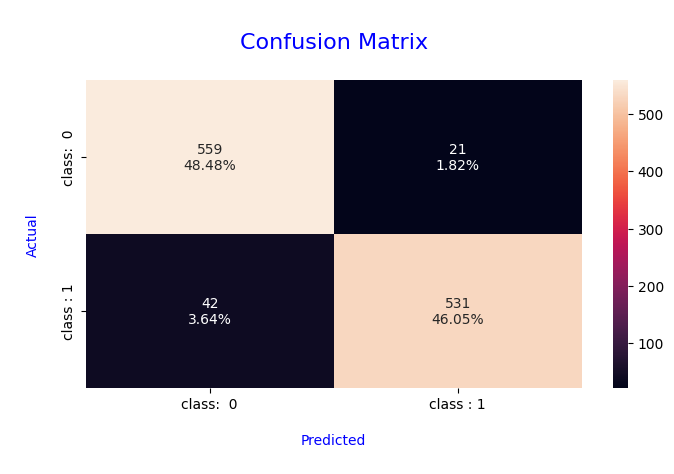

In [34]:
score_1 = model_evaluation(xgb_classifier, X_train_vec, X_test_vec, y_train_vec, y_test_vec)
scores_data['XGBoost'] = score_1

# **2. SVM Classifier**

In [35]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_vec, y_train_vec)
y_test_vec_prediction = SVM.predict(X_test_vec)
print(classification_report(y_test_vec, y_test_vec_prediction))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       580
           1       0.95      0.94      0.94       573

    accuracy                           0.95      1153
   macro avg       0.95      0.95      0.95      1153
weighted avg       0.95      0.95      0.95      1153




		  Train score  /  Test score

Accuracy  : 0.9534278275961816 / 0.9453599306157849
Recall    : 0.9534278275961816 / 0.9453599306157849
Precision : 0.9534720003231411 / 0.9455158425719158
F1 Score  : 0.953426855932662 / 0.9453517906294499


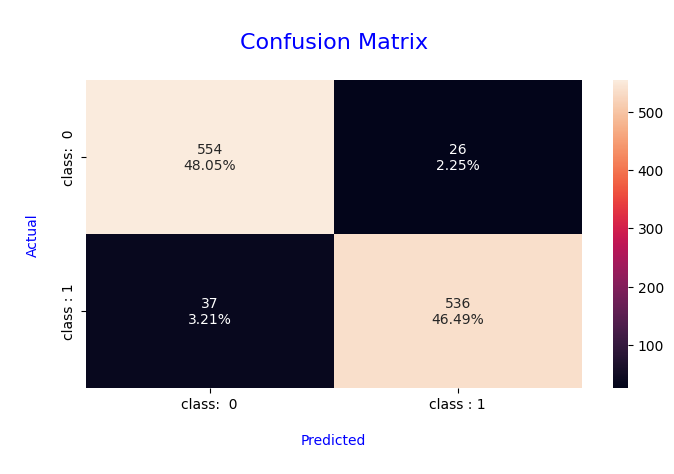

In [36]:
score_2 = model_evaluation(SVM, X_train_vec, X_test_vec, y_train_vec, y_test_vec)
scores_data['Support Vector'] = score_2

# **3. Random Forests**

In [54]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train_vec)
y_test_vec_prediction = rf.predict(X_test_vec)
print(classification_report(y_test_vec, y_test_vec_prediction))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       580
           1       0.94      0.94      0.94       573

    accuracy                           0.94      1153
   macro avg       0.94      0.94      0.94      1153
weighted avg       0.94      0.94      0.94      1153




		  Train score  /  Test score

Accuracy  : 0.993732523382509 / 0.9375542064180399
Recall    : 0.993732523382509 / 0.9375542064180399
Precision : 0.9937366425574554 / 0.9375581576950262
F1 Score  : 0.9937325041530373 / 0.9375533608597695


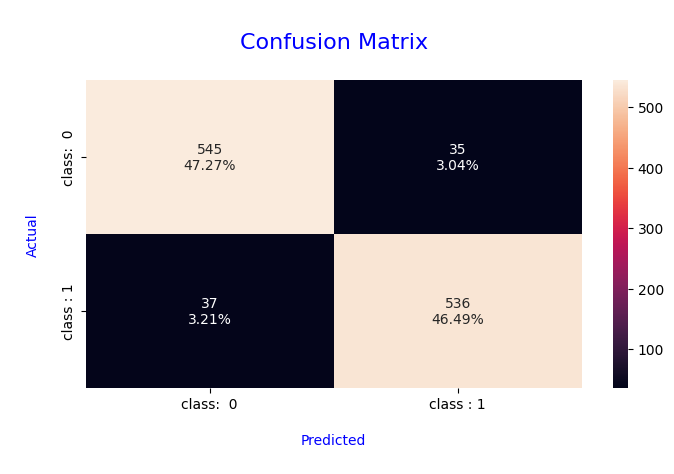

In [55]:
score_3 = model_evaluation(rf, X_train_vec, X_test_vec, y_train_vec, y_test_vec)
scores_data['Random Forests'] = score_3

# **4. Non-linear SVM**

In [40]:
nu_svm = svm.NuSVC(gamma="auto")
nu_svm.fit(X_train_vec, y_train_vec)
y_test_vec_prediction = nu_svm.predict(X_test_vec)
print(classification_report(y_test_vec, y_test_vec_prediction))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       580
           1       0.96      0.88      0.92       573

    accuracy                           0.92      1153
   macro avg       0.93      0.92      0.92      1153
weighted avg       0.93      0.92      0.92      1153




		  Train score  /  Test score

Accuracy  : 0.9210297946196124 / 0.9228100607111882
Recall    : 0.9210297946196124 / 0.9228100607111882
Precision : 0.923199665915063 / 0.9256035236953363
F1 Score  : 0.9209305212845343 / 0.9226623719816472


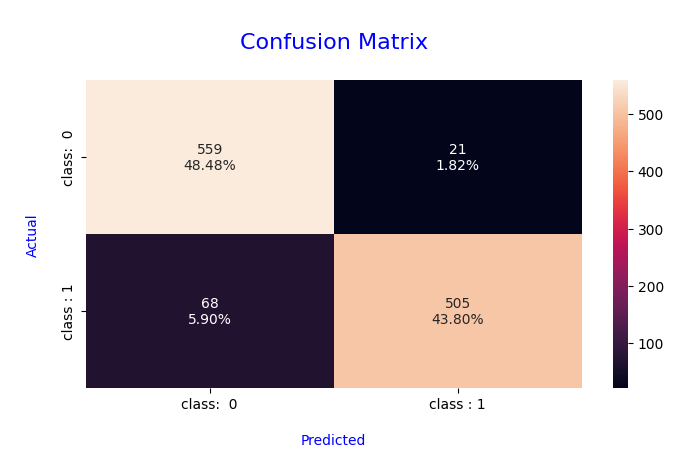

In [57]:
score_4 = model_evaluation(nu_svm, X_train_vec, X_test_vec, y_train_vec, y_test_vec)
scores_data['Non-linear SVM'] = score_4

# **5. MLPClassifier**

In [42]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(X_train_vec, y_train_vec)
y_test_vec_prediction = mlp.predict(X_test_vec)
print(classification_report(y_test_vec, y_test_vec_prediction))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       580
           1       0.96      0.94      0.95       573

    accuracy                           0.95      1153
   macro avg       0.95      0.95      0.95      1153
weighted avg       0.95      0.95      0.95      1153




		  Train score  /  Test score

Accuracy  : 0.9929611416449715 / 0.9479618386816999
Recall    : 0.9929611416449715 / 0.9479618386816999
Precision : 0.9929692073982487 / 0.9482185821765079
F1 Score  : 0.9929611031644056 / 0.9479503265764968


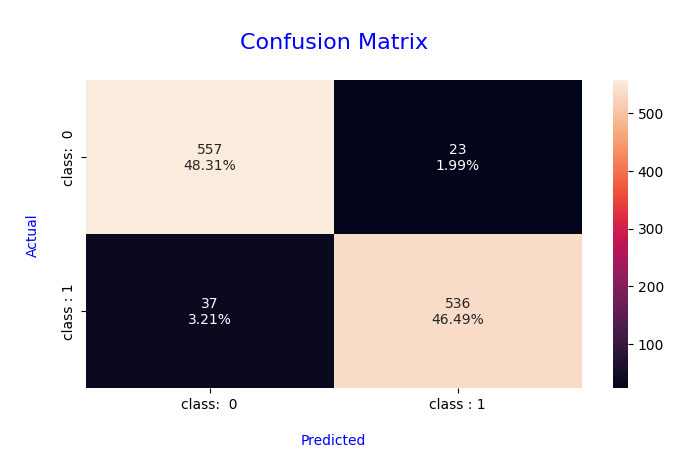

In [58]:
score_5 = model_evaluation(mlp, X_train_vec, X_test_vec, y_train_vec, y_test_vec)
scores_data['Multi-Layer Perceptron'] = score_5

# **6. Logistic Regression**

In [47]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_vec, y_train_vec)
y_test_vec_prediction = lr.predict(X_test_vec)
print(classification_report(y_test_vec, y_test_vec_prediction))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       580
           1       0.95      0.94      0.95       573

    accuracy                           0.95      1153
   macro avg       0.95      0.95      0.95      1153
weighted avg       0.95      0.95      0.95      1153




		  Train score  /  Test score

Accuracy  : 0.9493780734741105 / 0.9462272333044233
Recall    : 0.9493780734741105 / 0.9462272333044233
Precision : 0.9494776867909501 / 0.9463559043960214
F1 Score  : 0.9493755365589054 / 0.9462203555429433


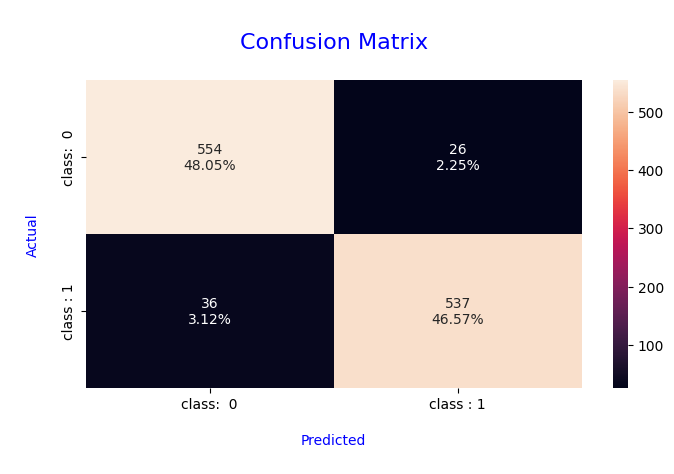

In [48]:
score_6 = model_evaluation(lr, X_train_vec, X_test_vec, y_train_vec, y_test_vec)
scores_data['Logistic Regression'] = score_6

# **7. GradientBoosting**

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

gradient = GradientBoostingClassifier()
gradient.fit(X_train_vec, y_train_vec)
y_test_vec_prediction_2 = gradient.predict(X_test_vec)
print(classification_report(y_test_vec, y_test_vec_prediction_2))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       580
           1       0.94      0.89      0.91       573

    accuracy                           0.92      1153
   macro avg       0.92      0.92      0.92      1153
weighted avg       0.92      0.92      0.92      1153




		  Train score  /  Test score

Accuracy  : 0.933275479703018 / 0.9176062445793582
Recall    : 0.933275479703018 / 0.9176062445793582
Precision : 0.9340164812464721 / 0.9187911023787967
F1 Score  : 0.9332479880179657 / 0.917533155421221


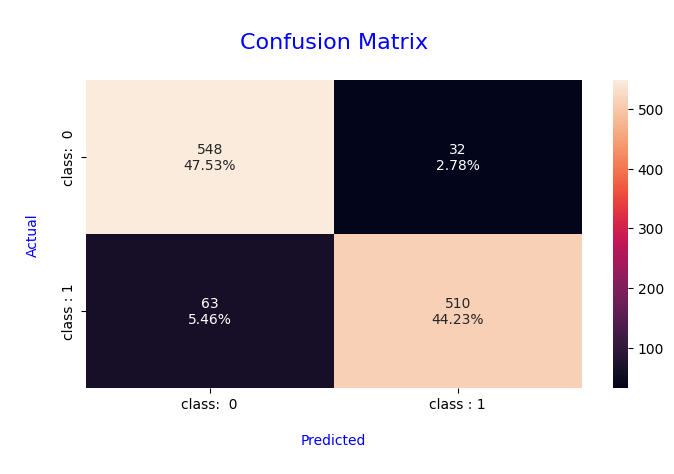

In [50]:
score_7 = model_evaluation(gradient, X_train_vec, X_test_vec, y_train_vec, y_test_vec)
scores_data['Gradient Boosting'] = score_7

# **Model Comparison on Testing Data**

In [59]:
score_df = pd.DataFrame(scores_data).T
score_df.columns = ['accuracy', 'recall', 'precision', 'f1-score']
score_df

,accuracy,recall,precision,f1-score
Logistic Regression,0.946227,0.946227,0.946356,0.946220
XGBoost,0.945360,0.945360,0.945940,0.945336
Support Vector,0.936687,0.936687,0.936688,0.936687
Random Forests,0.937554,0.937554,0.937558,0.937553
Non-linear SVM,0.922810,0.922810,0.925604,0.922662
Multi-Layer Perceptron,0.947962,0.947962,0.948219,0.947950
Gradient Boosting,0.917606,0.917606,0.918791,0.917533


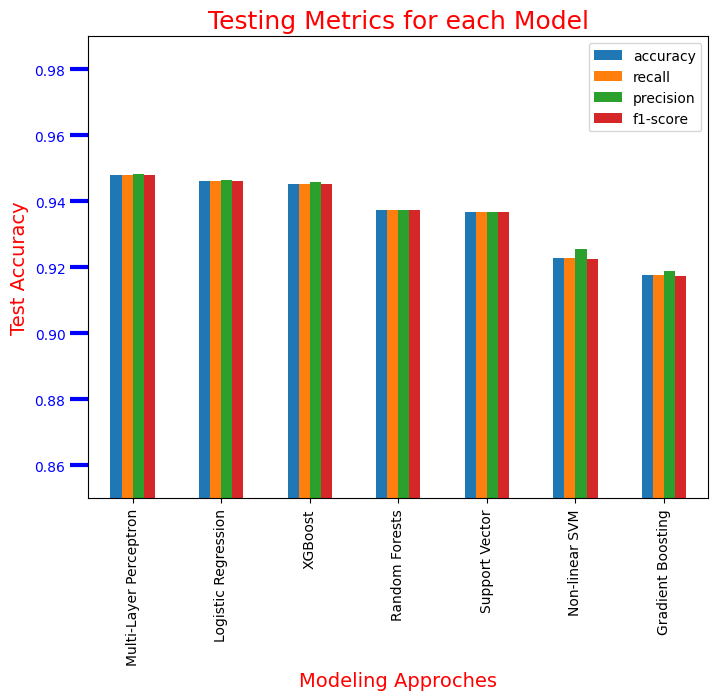

In [60]:
score_df.sort_values('accuracy',ascending = False).plot(kind='bar',figsize=(8,6))
plt.title("Testing Metrics for each Model",fontsize=18,color='red')
plt.tick_params(axis='y', colors='blue', direction='out', length=13, width=3)
plt.xlabel("Modeling Approches", fontsize=14, color = 'red')
plt.ylim([0.85, 0.99])
plt.ylabel("Test Accuracy", fontsize=14, color = 'red')
plt.show()

# **Save the Encoder and Model into local file**

In [62]:
with open('MLP_model.pkl','wb') as f:
    pickle.dump(mlp,f)
with open("vectorizer.pkl", "wb") as vec_f:
  pickle.dump(tfidf_vectorizer, vec_f)

# **Load the model and encoder**

In [64]:
with open('MLP_model.pkl', 'rb') as f:
  clf = pickle.load(f)
with open('vectorizer.pkl', 'rb') as vec_f:
  vectorizer = pickle.load(vec_f)

In [67]:
def preprocess_input(text_list):
  cleaned_text = []
  for idx in range(len(text_list)):
      sentence = text_list[idx]
      removeSpecialChars = str(sentence).translate ({ord(c): " " for c in "!@#$%^&*()[]{};:,./<>?\|`~-=_+"})
      pattern = r'[0-9]'
      new_string = re.sub(pattern, '', removeSpecialChars)
      new_string = re.sub(' +', ' ', new_string)
      new_string = ' '.join([word for word in new_string.split() if word not in stopwords.words("english")])
      new_string = ' '.join( [lemmatizer.lemmatize(w).lower() for w in new_string.split() if len(w)>1 and w not in special_words] )
      cleaned_text.append(new_string)
  return cleaned_text


# **How to predict the label for input text**

In [69]:
new_input = ["What’s everybodies thoughts today?", "Anything good to buy now? Or did I miss it "]
input = preprocess_input(new_input)
input

['what’s everybodies thought today', 'anything good buy or miss']

In [70]:
input = vectorizer.transform(input)

In [71]:
prediction = clf.predict(input)
prediction

array([1, 1])